## Merge run1 and run3

Zhiyuan Hu \
1 June 2024

In [1]:
import datetime
## last modified
current_date = datetime.datetime.now().strftime("%B %d, %Y")
current_time = datetime.datetime.now().strftime("%I:%M %p")
current_date + ", "+current_time

'June 08, 2024, 08:59 PM'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

import scanpy as sc
import squidpy as sq

sc.logging.print_header()

/home/huzhiy/miniforge3/envs/squidpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.5 anndata==0.10.1 umap==0.5.4 numpy==1.26.4 scipy==1.11.3 pandas==2.2.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.9.11 pynndescent==0.5.10


## merscope NC vs multiome NC

### read spatial data

In [3]:
ad_sp3 = sc.read_h5ad('merscope/merscope_run3/data/20240522_run3_minexp10_squidpy_adata.hdf5')
ad_sp3.obs.loc[ad_sp3.obs['regions'].isin(['most right', 'between line1 and line2']), 'sample'] = "wt_early"
ad_sp3.obs.loc[~ad_sp3.obs['regions'].isin(['most right', 'between line1 and line2']), 'sample'] = "mut_late"

ad_sp3

AnnData object with n_obs × n_vars = 10345 × 299
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_280_genes', 'n_counts', 'leiden', 'regions', 'Cell_Type', 'Cluster', 'sample'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_centrality_scores', 'leiden_colors', 'leiden_nhood_enrichment', 'leiden_ripley_L', 'log1p', 'neighbors', 'pca', 'regions_colors', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [4]:
ad_sp3.obs['sample'].value_counts()

sample
wt_early    5561
mut_late    4784
Name: count, dtype: int64

In [5]:
ad_sp1 = sc.read_h5ad("merscope/analysis/clustering_mapping/data/20240424_run1_minexp10_squidpy_adata.hdf5")
ad_sp1.obs['sample'] = "wt_late"
ad_sp1

AnnData object with n_obs × n_vars = 15718 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'leiden', 'Cell_Type', 'Cluster', 'sample'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_centrality_scores', 'leiden_colors', 'leiden_nhood_enrichment', 'leiden_ripley_L', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
   

In [6]:
# Merge the two AnnData objects
adata = anndata.concat([ad_sp1, ad_sp3])
adata.X = adata.layers['counts']

In [7]:
adata.X 

<26063x299 sparse matrix of type '<class 'numpy.float32'>'
	with 1039367 stored elements in Compressed Sparse Row format>

In [8]:
sc.pp.filter_cells(adata, min_counts=10)

In [9]:
del adata.obsm['X_pca']

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

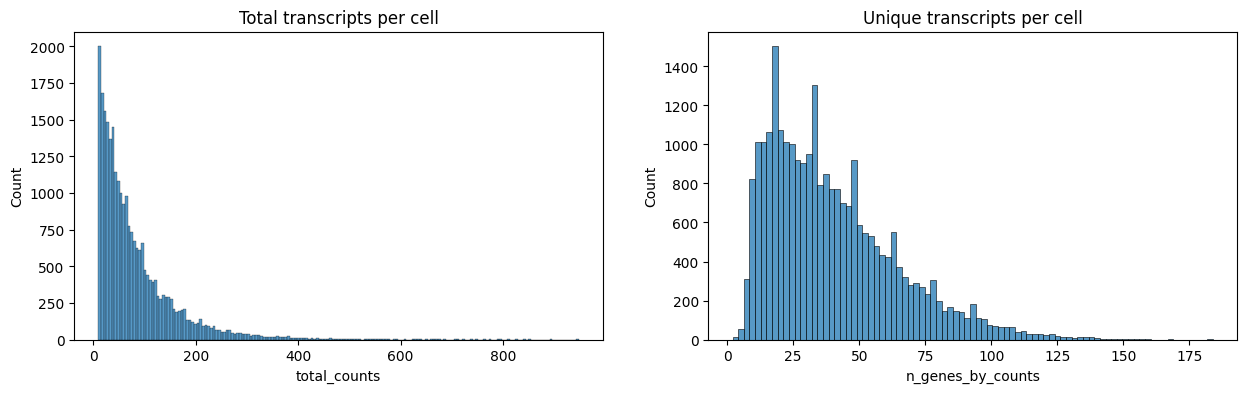

In [10]:
# Next we plot the distribution of total transcripts per cell, unique transcripts per cell, transcripts per FOV and the volume of the segmented cells
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

In [11]:
adata.X

<26063x299 sparse matrix of type '<class 'numpy.float32'>'
	with 1039367 stored elements in Compressed Sparse Row format>

In [12]:
resolution = 1.5

# Leiden Clustering
######################

# dividing by volume instead
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=resolution)

/home/huzhiy/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/huzhiy/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


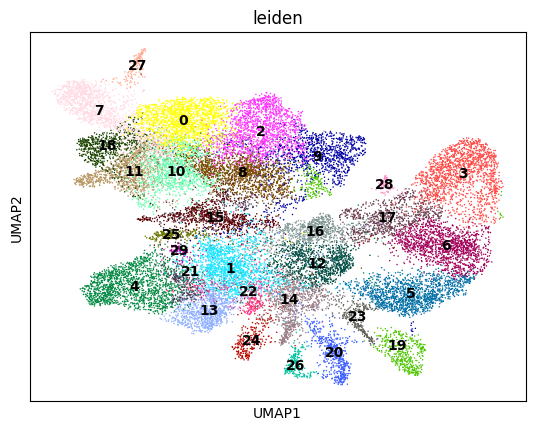

In [13]:
# Calculate Leiden Signatures
#########################################df_pos.index = [str(x) for x in list(range(df_pos.shape[0]))]
ser_counts = adata.obs['leiden'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)

cat_name = 'leiden'
sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
for clust in adata.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ['Leiden-' + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden['leiden'] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

# generate colors for categories by plotting
sc.pl.umap(adata, color="leiden", legend_loc='on data')
cats = adata.obs['leiden'].cat.categories.tolist()
colors = list(adata.uns['leiden_colors'])
cat_colors = dict(zip(cats, colors))

# colors for clustergrammer2
ser_color = pd.Series(cat_colors)
ser_color.name = 'color'
df_colors = pd.DataFrame(ser_color)
df_colors.index = ['Leiden-' + str(x) for x in df_colors.index.tolist()]

df_colors.loc[''] = 'white'

/home/huzhiy/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/huzhiy/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


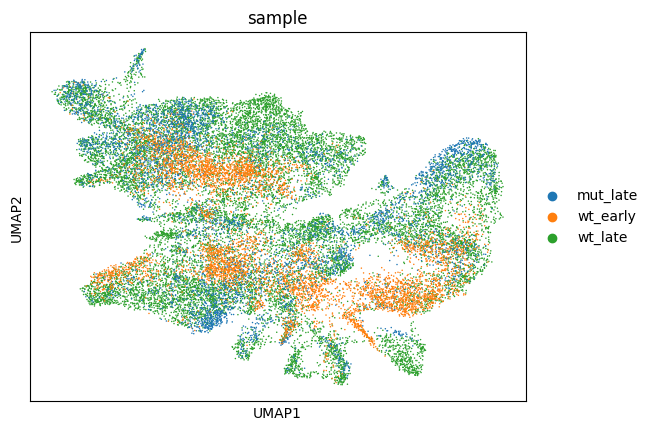

In [14]:
sc.pl.umap(adata, color="sample")

In [15]:
adata.obs['leiden'].value_counts()

leiden
0     1679
1     1645
2     1612
3     1555
4     1550
5     1395
6     1388
7     1386
8     1342
9     1128
10    1098
11    1092
12     987
13     933
14     923
15     911
16     756
17     748
18     670
19     622
20     548
21     451
22     323
23     300
24     281
25     210
26     208
27     149
28      92
29      81
Name: count, dtype: int64

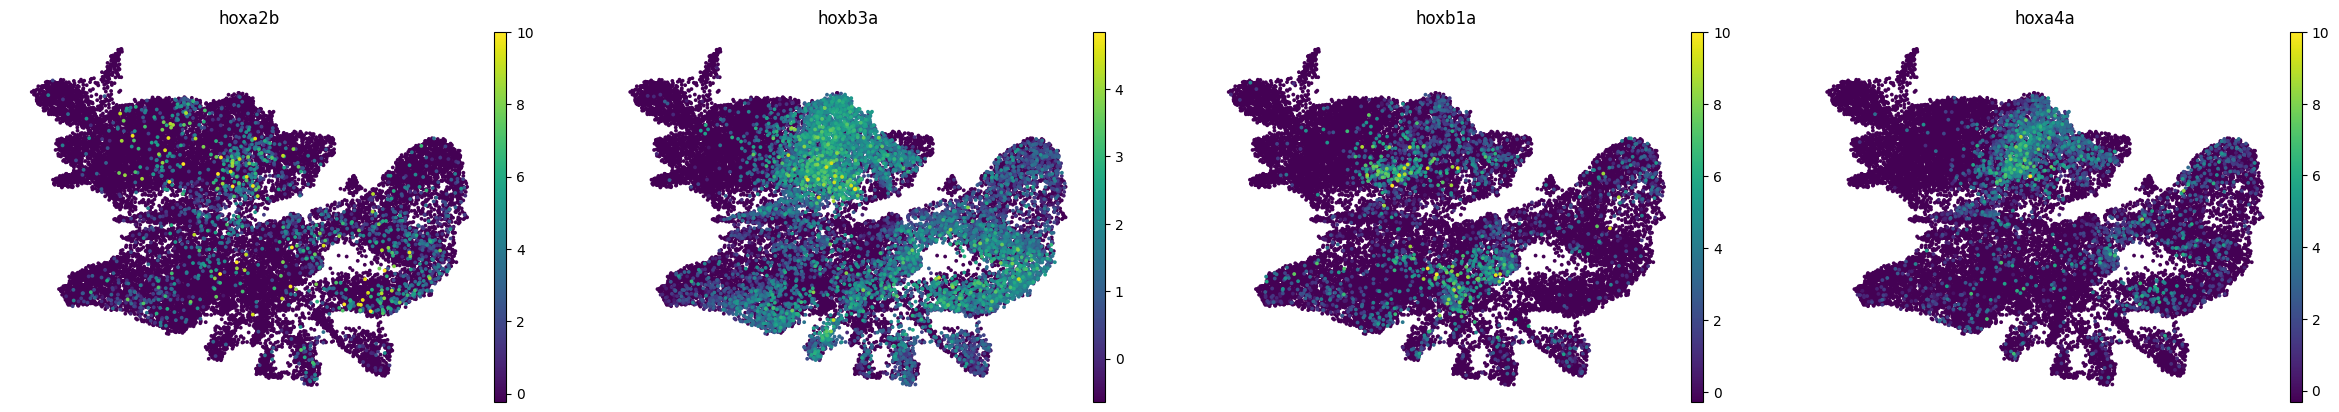

In [70]:
import re
hox_genes = [gene for gene in adata.var_names if re.search('hox', gene, re.IGNORECASE)]
sc.pl.umap(adata, color=hox_genes, size=30, frameon=False)

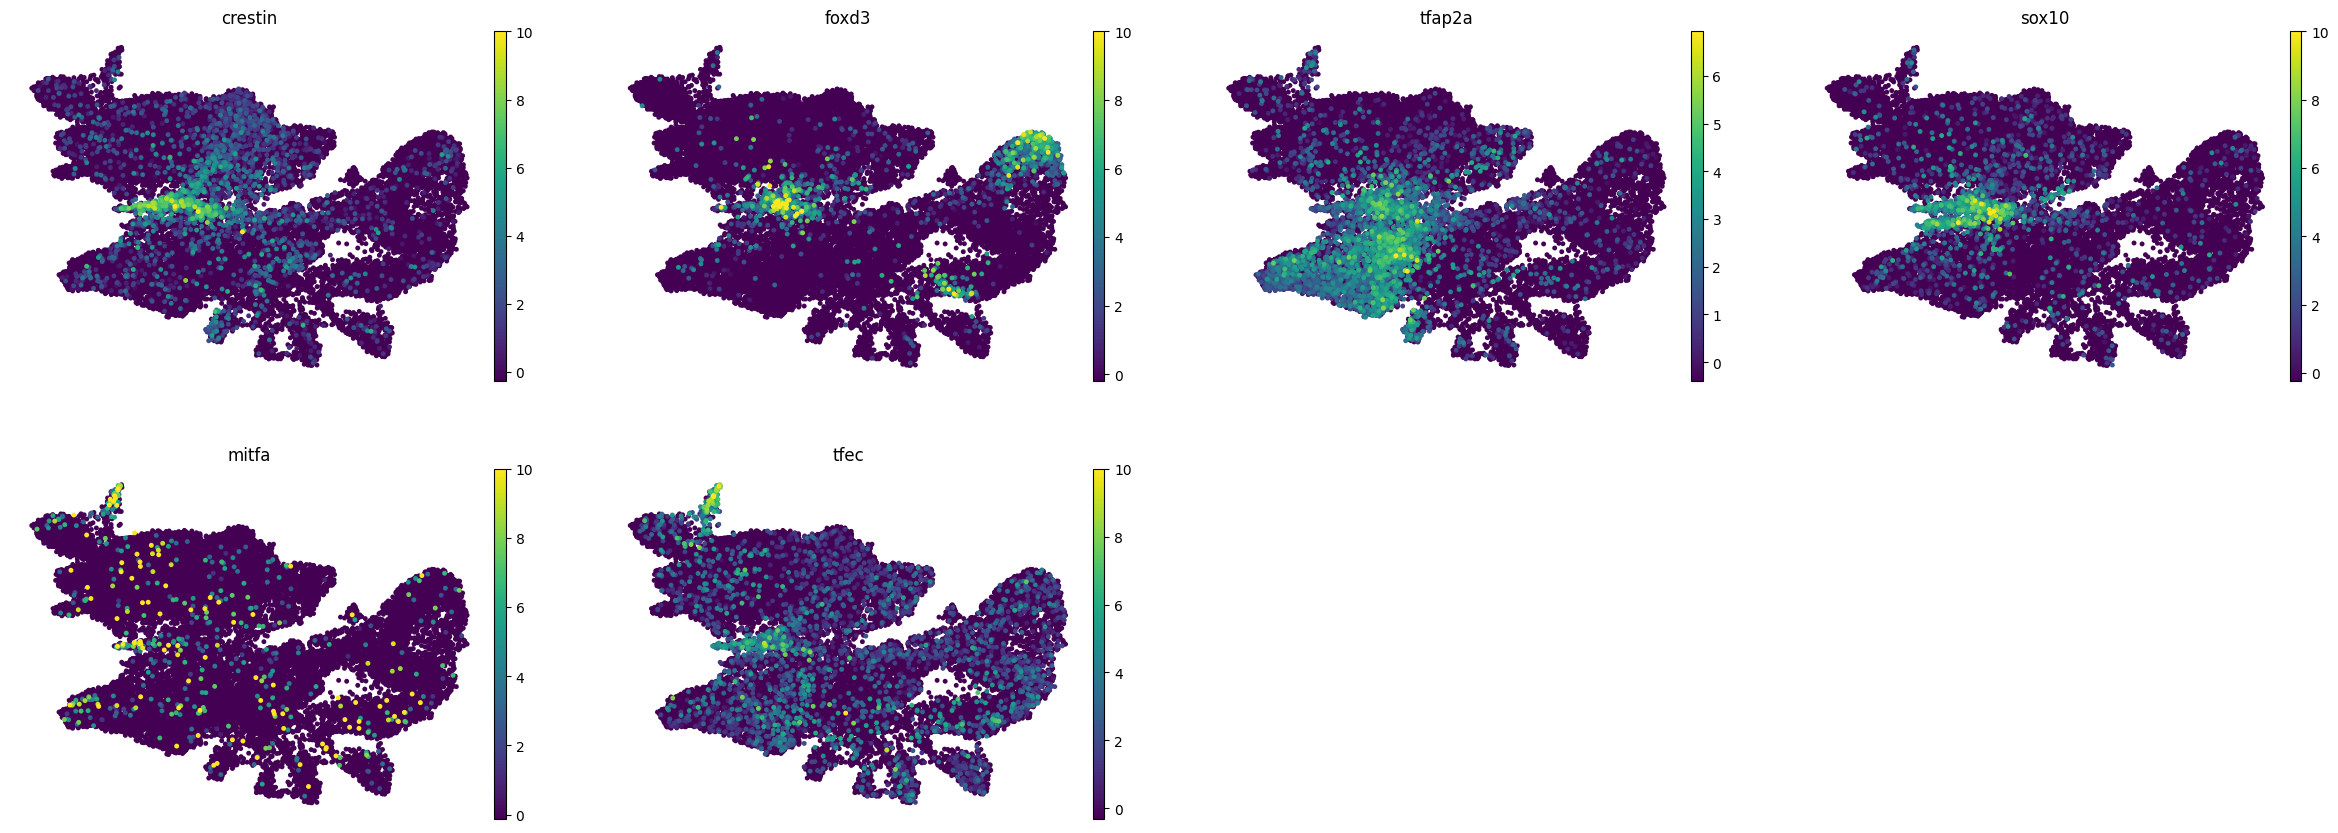

In [74]:
sc.pl.umap(adata, color=["crestin","foxd3","tfap2a", "sox10","mitfa","tfec"], size=50, frameon=False)

In [76]:
adata.write_h5ad("merscope/merscope_run3/results/run1_3/ad_run1_run3_allCells_reclustered.h5ad")